In [1]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from  mlflow.tracking import MlflowClient

from sentence_transformers import SentenceTransformer,models
import plotly.express as px
import pandas as pd

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from pprint import pprint
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score

remote_server="http://ec2-18-193-70-141.eu-central-1.compute.amazonaws.com"
client = MlflowClient(remote_server)
mlflow.set_tracking_uri(remote_server)

os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://s3.eu-central-1.amazonaws.com"
os.environ["MLFLOW_TRACKING_USERNAME"]="mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"]="mlflow"
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext utils
%reload_ext modeling

## Load the labeled data and their Named entities

In [5]:
X = utils.load_labeled_data()
X.drop(["site","entities_analyzed","updated_at"],inplace=True,axis="columns")

labeled = pd.read_csv("../data/raw_article_entities.csv",header=None,names=["_id","article_id",
                                                                            "kicker_headline_NER","text_NER",
                                                                            "seo_title_NER","created_at_ne",
                                                                            "updated_at","parset"])

labeled.drop(["parset","updated_at","_id"],axis=1,inplace=True)
labeled = labeled.set_index("article_id")


X['mix'] =  X['headline'] +" "+ X["seo_title"].apply(utils.remove_seo_title_marker) #+ X["text"].apply(lambda x: " ".join(x.split(" ")[:150]))
#pdf_mix = utils.preprocess_text(X,col="mix")
pdf_mix = X["mix"].values
X = X.join(labeled,how='right')
X.drop_duplicates(subset='headline',inplace=True)
pdf= utils.preprocess_articles_for_bert(X,"text")
y = X.labels
X.drop("labels",axis="columns",inplace=True)
X.tail(1)


,headline,seo_title,text,created_at_date,created_at,mix,kicker_headline_NER,text_NER,seo_title_NER,created_at_ne
fde4b3c95901643bf957060e97458af3c3a5cb77979d6b1cab666bd11a343918,„FameMaker“: Wie Stefan Raab die Fäden weiter ...,Wie Raab hinter der Kamera die Fäden zieht,Bühne frei für ein neues bisschen Raab ... Am ...,9/14/20,2020-09-14 18:27:15,„FameMaker“: Wie Stefan Raab die Fäden weiter ...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-14 18:28:06


In [27]:
word_embedding_model = models.Transformer('T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')
emb = modeling.get_sentence_embeddings(pdf,word_embedding_model)




--- Embedding dimension 768
--- 239 Documnets encoded 24.07139301300049 seconds ---
(239, 768)


In [44]:
#Loading Emebddings from the big file 
#emb_ids=np.load("../models/bert-german-dbmdz-uncased-sentence-stsb/Top-100k_articles_embddings_ids.npy",allow_pickle=True)
#emb_df = pd.DataFrame(emb_ids,columns=['article_id',"embedding"]).set_index("article_id")

#emb = X.join(emb_df,how='left').embedding.to_numpy()
#emb = np.stack(emb, axis=0)

In [49]:

params = {"alpha":.80,"min_samples":2,"min_cluster_size":4,"allow_single_cluster":False}
umap_model="umap_100k_6-neighbors_256-comps.pkl"
umap_data, labels =modeling.load_umap_and_cluster(_emb,umap_model=umap_model,**params)
docs_df = utils.relink_data_after_clustering(umap_data,X,labels)

--- UMAP Loaded in 1.779430866241455 seconds ---
Outliers: 26 | Clustered: 213 | 0.891213389121339 
 Cluster count: 23 


In [50]:
results = utils.link_to_raw_data(umap_data,X,labels)

y_summarized_clusters = dict(collections.Counter(y.values))

mlflow.set_experiment("basic-eval")
with mlflow.start_run():
    mlflow.log_params(params)
    # For every topic collect all the article and join their texts (preprocessed) , raw texts,
    mlflow.log_param("umap",umap_model)
    docs_per_topic = docs_df.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                       'headline': '. '.join,
                                                                        "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                          "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                            "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                            }).set_index("topic_number")
    
    mlflow.log_metric(key="completeness_score", value=completeness_score(labels,y.values))
    mlflow.log_metric(key="v_measure_score", value=v_measure_score(labels,y.values))
    mlflow.log_metric(key="homogeneity_score", value=homogeneity_score(labels,y.values))
    mlflow.log_metric(key="normalized_mutual_info_score", value=v_measure_score(labels,y.values))

    summarized_clusters = dict(collections.Counter(labels))
    try:
        mlflow.log_metric(key="outliers_ratio", value=(summarized_clusters[-1]/len(labels)))
    except Exception as err:
        mlflow.log_metric(key="outliers_ratio", value=0)

    mlflow.log_metric(key="unique_cluters", value=len(summarized_clusters.items()))
    mlflow.log_metric(key="clusters_ratio_to_GT", value=(len(summarized_clusters.items())-1)/len(y_summarized_clusters.items()))
    mlflow.log_metric(key="silhuette_score", value=silhouette_score(emb,labels))

    results = utils.link_to_raw_data(results,X,labels)
    
    try:
        modeling.scatter_plot(results,save_fig=True)
        mlflow.log_artifact("./tmp_scatter_plot.html")
    except Exception as err:
        print(err)



Outliers: 26 | Clustered: 213 | 0.891213389121339 
 Cluster count: 23 
Outliers: 26 | Clustered: 213 | 0.891213389121339 
 Cluster count: 23 


In [ ]:
ctrs=[]
for topic in docs_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]
    seo_title_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ] * 2
    kicker_headline_entities = [elem["text"] for elem in docs_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ] * 3
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:8]

    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_per_topic.index.values,ctrs)}    


cluster_labels_google = pd.DataFrame(zip(docs_per_topic.index.values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")

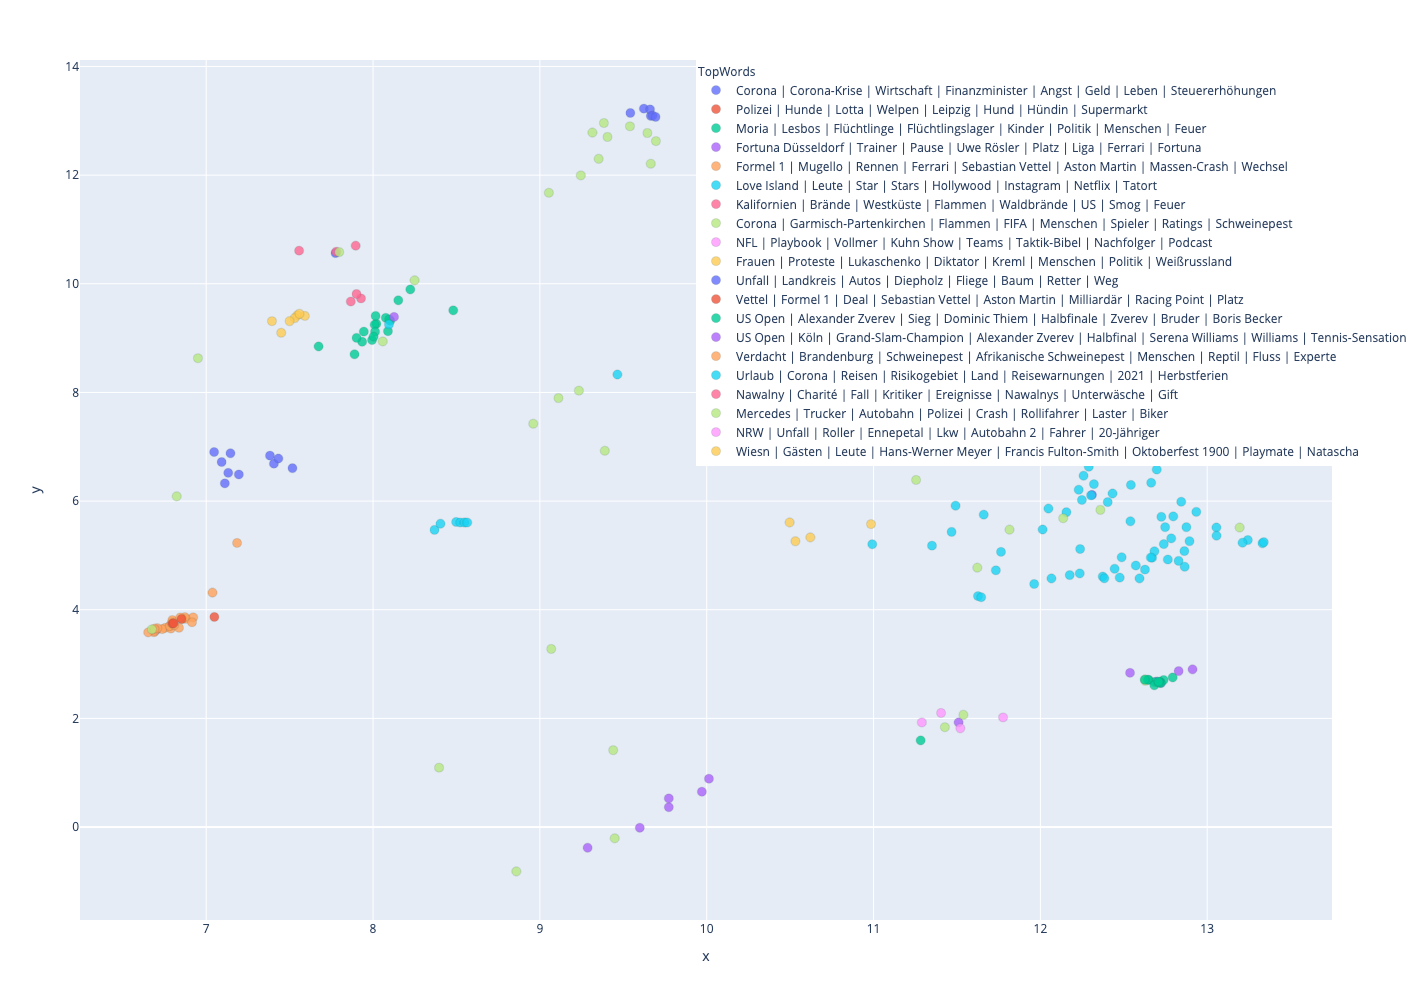

In [94]:
                      
results["labels"] = results.labels.apply(int)
cluster_labels_google = pd.DataFrame(zip(docs_per_topic.index.values,[" | ".join([word[0] for word in word_score]) for word_score in ctrs]),columns=["Topic","TopWords"]).sort_values(by="Topic").set_index("Topic")


In [ ]:
results=pd.merge(results,cluster_labels_google.reset_index(),left_on="labels",right_on = "Topic")
fig = px.scatter(results, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords"], color="TopWords",
                 opacity=0.8)
fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

In [109]:
def mlflow_run_model_eval(mlflow,embeddings,df,**kwargs):
    with mlflow.start_run():

        #mlflow.log_params(kwargs)

        results,cluster_labels = modeling.c(embeddings,n_components_clustering=N_COMPONENTS,
                                                             min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                             min_samples= min_samples,alpha=alpha)
        mlflow.log_metric(key="completeness_score", value=completeness_score(cluster_labels,y.values))
        mlflow.log_metric(key="v_measure_score", value=v_measure_score(cluster_labels,y.values))
        mlflow.log_metric(key="homogeneity_score", value=homogeneity_score(cluster_labels,y.values))
        mlflow.log_metric(key="normalized_mutual_info_score", value=v_measure_score(cluster_labels,y.values))

        summarized_clusters = dict(collections.Counter(cluster_labels))
        try:
            mlflow.log_metric(key="outliers_ratio", value=(summarized_clusters[-1]/len(cluster_labels)))
        except Exception as err:
            mlflow.log_metric(key="outliers_ratio", value=0)

        mlflow.log_metric(key="unique_cluters", value=len(summarized_clusters.items()))
        mlflow.log_metric(key="cluters_ratio_to_GT", value=(len(summarized_clusters.items())-1)/len(y_summarized_clusters.items()))
        #mlflow.log_metric(key="silhuette_score", value=silhouette_score(_X,cluster_labels))

        results = utils.link_to_raw_data(results,df,cluster_labels)

        modeling.scatter_plot(results,save_fig=True)
        mlflow.log_artifact("./tmp_scatter_plot.html")
    

,x,y,topic_number,headline,seo_title,raw_text,article_uid,kicker_headline_ne,text_ne,seo_title_ne,created_at
0,7.195629,6.489958,10,Die große Analyse - Welche Versicherung muss s...,"Welche Versicherung muss sein, welche ist Quat...","Corona-Krise, Kurzarbeit, steigende Arbeitslos...",01041edd835d23b5fc1da3f45bd9eecee20712902612a0...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-12
1,11.686262,8.517100,14,Dortmund: Tierschützer retten verwahrloste Dac...,Tierschützer retten völlig verwahrloste Dackel,Dortmund – Diese Hilfs-Aktion hat wahrscheinli...,0177704b8dba48b9f78a4e7e40bdf147ca407c121f32e2...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13
2,8.019990,9.263278,12,Kommentar zur Lage in Moria - Die Kinder von M...,Die Kinder von Moria brauchen unsere Hilfe,Wenn man an der Feuerkatastrophe im Flüchtling...,02269300addef66e501d2bb13124a1729135ebbb923ee4...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-10
3,9.971060,0.650199,8,Fortuna Düsseldorf: Drüsenfieber! Emma Iyoha d...,Iyoha drohtlange Pause!,Vor zwei Tagen trabte Fortuna-Profi Emmanuel I...,02bdfc4160d2b5fd6c4c0ca1b890db57880964b29e8f66...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-10
4,6.881146,3.833338,4,Formel 1: Mick Schumacher fährt Rekord-Ferrari...,Mick fährt SchumisRekord-Ferrari,Dass Ferrari in der Formel 1 für Gänsehaut sor...,0368404e36a88feab9248096fb7ea8e56fa42e498e6ef2...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13
...,...,...,...,...,...,...,...,...,...,...,...
234,7.432632,6.783584,10,Finanzielle Engpässe: Wie stark belastet Coron...,Wie stark belastet Corona unseren Geldbeutel?,Die Corona-Pandemie macht sich seit Monaten im...,faae5f2ef63c63baae47bc98fb1cb2a40274156a3508a9...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13
235,9.389167,6.926017,-1,Corona in Garmisch-Partenkirchen | Pub-Bertrei...,Pub-Betreiber total fertig: „Das ist eine Kata...,Eine 26-jährige Super-Spreaderin verursachte a...,fab9f708d9ba4e68959eea74ace58df6fee0449bdb6e71...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-13
236,7.900997,9.811699,16,Nawalny: War das Nowitschok-Gift auf seiner Un...,War das Gift auf der Unterwäsche Nawalnys?,War es doch nicht der Tee am Flughafen? Der N...,fd3215b0fc56e66a2ffd49b7976413dc5ef1aae4cbc1fd...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-11
237,7.556959,10.609605,3,Dutzende werden vermisst - 35 Tote durch Kalif...,35 Tote durch Kalifornien-Brände,Das Flammen-Inferno in Kalifornien fordert imm...,fdbd80734a8be7d3cab1c0a450442219166af24e9c2a92...,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",2020-09-14
